# Table of Contents
- Goal
- Importing libraries
- Reading data
- Plot Settings
- EDA
- Preparing the data for ML model
- ML model
 - MultinomialNB
- Conclusion    

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline

# Reading data

In [2]:
df=pd.read_csv('Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [3]:
df.shape

(21459, 2)

# Plot Settings

In [4]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 23
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['figure.figsize'] = 7,4
sns.set_style('ticks')

# EDA
### Missing values


In [5]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

### Unique values

In [6]:
df.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

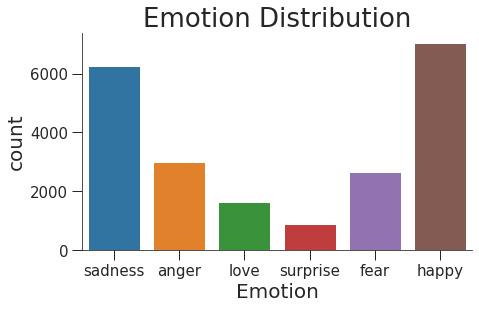

In [7]:
sns.countplot(x=df.Emotion)
plt.title('Emotion Distribution',size=26)
sns.despine(left=False)
plt.savefig('distribution.png',dpi=300)

In [8]:
df.Emotion=pd.Categorical(df.Emotion)  # changing dtype to categorical
df['Emotion_cat']= df.Emotion.cat.codes
df.head()

,Text,Emotion,Emotion_cat
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


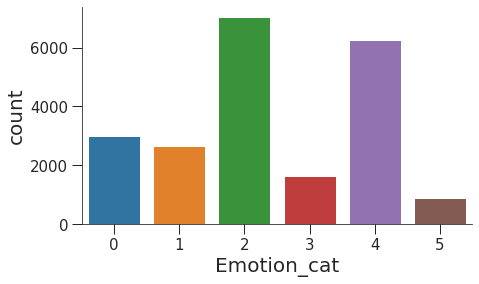

In [9]:
sns.countplot(x=df.Emotion_cat)
sns.despine(left=False)

### Some sentiment analysis (not needed but just for fun)

In [10]:
from textblob import TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        result = "positive"
    elif sentiment < 0:
        result="negative"
    else:
        result="neutral"
    return result    

In [11]:
df["sentiment"]=df["Text"].apply(get_sentiment)

In [12]:
df.head()

,Text,Emotion,Emotion_cat,sentiment
0,i didnt feel humiliated,sadness,4,neutral
1,i can go from feeling so hopeless to so damned...,sadness,4,neutral
2,im grabbing a minute to post i feel greedy wrong,anger,0,negative
3,i am ever feeling nostalgic about the fireplac...,love,3,negative
4,i am feeling grouchy,anger,0,neutral


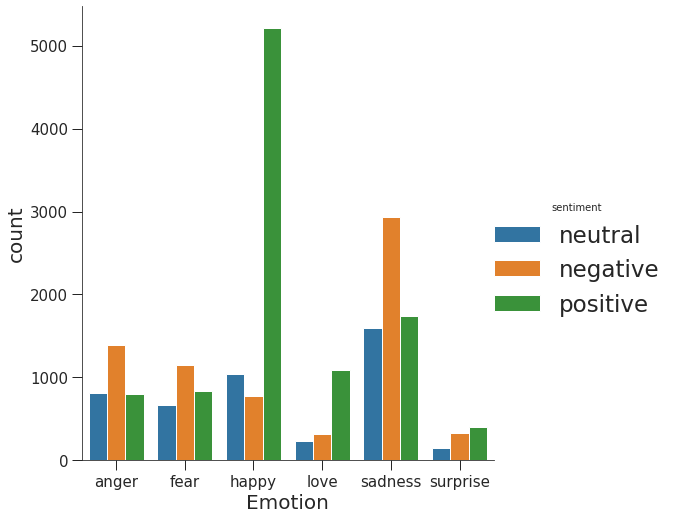

In [13]:
sns.catplot(x='Emotion',hue='sentiment',data=df,kind='count',height=7)
plt.savefig('sentiment_analysis.png',dpi=300)

### Cleaning data

In [14]:
def cleantext(data):   
    data = re.sub(r'@[A-Za-z0-9]+', '', data) # remove @mentions
    data = re.sub(r'#', '', data)# remove # tag
    data = re.sub(r'RT[\s]+', '', data) # remove the RT
    data = re.sub(r'https?:\/\/\S+', '', data) # remove links
    data = re.sub('(\\\\u([a-z]|[0-9])+)', ' ', data) # remove unicode characters
    data = re.sub(r'"', '', data)
    data = re.sub(r':', '', data)
    return data

In [15]:
df["Text"]=df["Text"].apply(cleantext)

In [16]:
df['Text']=df['Text'].dropna()

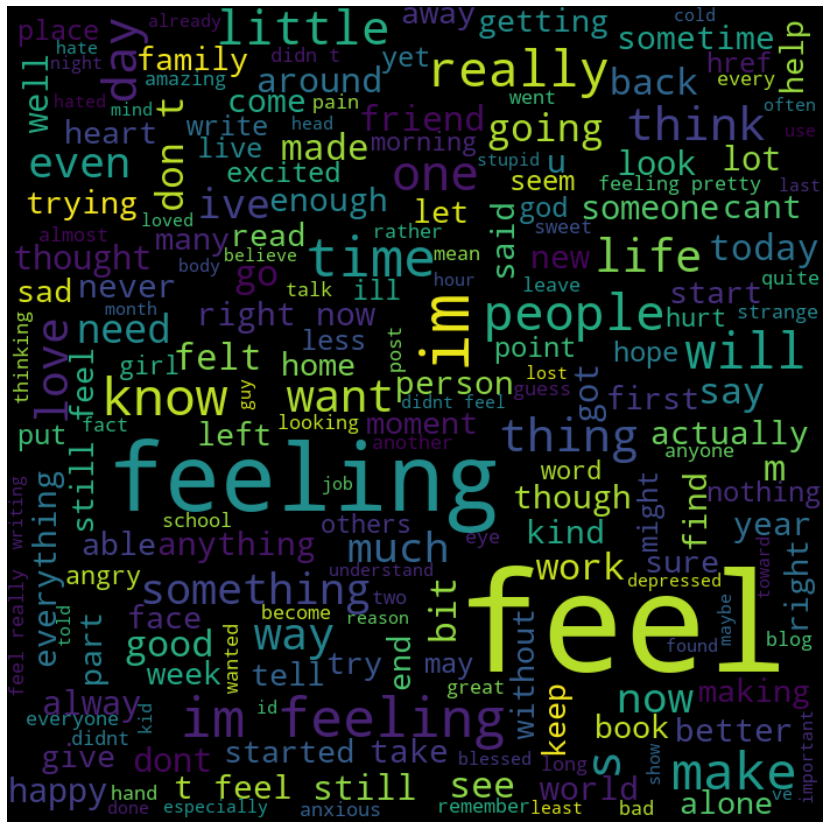

In [17]:
#finding most common words in the dataset

word= ' '.join([twts for twts in df['Text']])
clude= WordCloud(width=700, height=700, random_state= 0,min_font_size=15,max_font_size=119).generate(word)
plt.figure(figsize = (15,15))
plt.imshow(clude,interpolation='bilinear')
plt.axis('off')
plt.savefig('most_common_word.png',dpi=300)
plt.show()


In [18]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.Emotion_cat
features.shape

(21459, 6133)

In [19]:
i=0
N=2
for Emotion_cat, Emotion  in sorted(df.Emotion_cat.items()):
  features_chi2 = chi2(features, labels == Emotion_cat)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Emotion))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  i=i+1
  if(i==5):
    break

# '4':
  . Most correlated unigrams:
. resentful
. offended
  . Most correlated bigrams:
. feel offended
. feel resentful
# '4':
  . Most correlated unigrams:
. frightened
. anxious
  . Most correlated bigrams:
. feel pressured
. feel threatened
# '0':
  . Most correlated unigrams:
. confident
. successful
  . Most correlated bigrams:
. feel privileged
. feel honored
# '3':
  . Most correlated unigrams:
. longing
. sympathetic
  . Most correlated bigrams:
. feel longing
. feel sympathetic
# '0':
  . Most correlated unigrams:
. punished
. miserable
  . Most correlated bigrams:
. feel bad
. feel ashamed


# Preparing data for ML model

In [20]:
vectorizer = CountVectorizer(max_features=1500,  stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df['Text']).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
y=df['Emotion']

## Splitting the data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2, random_state=10)

In [23]:
from imblearn.over_sampling import SMOTE
rs = SMOTE(sampling_strategy='auto')
X_train,y_train = rs.fit_resample(X_train,y_train)

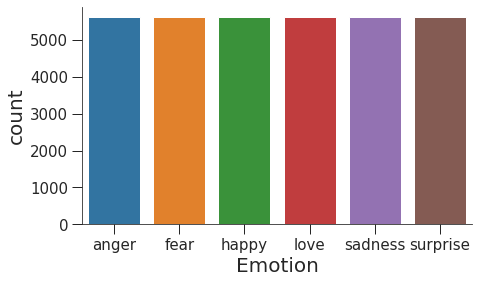

In [24]:
sns.countplot(x=y_train)
sns.despine(left=False)
plt.savefig('balanced.png',dpi=300)

# ML model

In [25]:
mnb = MultinomialNB().fit(X_train, y_train)

In [28]:
y_train_pred =mnb.predict(X_train)
y_test_pred  = mnb.predict(X_test)

print("Training Accuracy:",accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:",accuracy_score(y_test, y_test_pred))
print("Testing F1 score:",f1_score(y_test, y_test_pred,average='weighted'))

Training Accuracy: 0.898897385737151
Testing Accuracy: 0.8224603914259087
Testing F1 score: 0.8275199794576686


In [29]:
from sklearn.model_selection import cross_val_score
k_fold_mnb_accuracy = cross_val_score(mnb, X,y, cv=5) ##5-fold cross validation
k_fold_mnb_f1 = cross_val_score(mnb, X, y, cv=5,scoring='f1_weighted') ##5-fold cross validation

print(f'Average accuracy after 5 fold cross validation : {k_fold_mnb_accuracy.mean().round(2)} +/- {k_fold_mnb_accuracy.std().round(2)}')
print(f'Average F1-score after 5 fold cross validation : {k_fold_mnb_f1.mean().round(2)} +/- {k_fold_mnb_f1.std().round(2)}')

Average accuracy after 5 fold cross validation : 0.79 +/- 0.04
Average F1-score after 5 fold cross validation : 0.77 +/- 0.05


In [30]:
def normalized_confusion_matrix(y_test, conf_mat, model):
    _ , counts = np.unique(y_test,return_counts=True)
    conf_mat = conf_mat/counts
    plt.figure(figsize=(20,8))
    ax=sns.heatmap(conf_mat,fmt='.2f',annot=True,annot_kws={'size':20},lw=2, cbar=True, cbar_kws={'label':'% Class accuracy'})
    plt.title(f'Confusion Matrix ({model})',size=22)
    plt.xticks(size=20)
    plt.yticks(size=20)
    ax.figure.axes[-1].yaxis.label.set_size(20) ##colorbar label
    cax = plt.gcf().axes[-1] ##colorbar ticks
    cax.tick_params(labelsize=20) ## colorbar ticks
    plt.savefig(f'confusion-matrix-{model}.png',dpi=300)

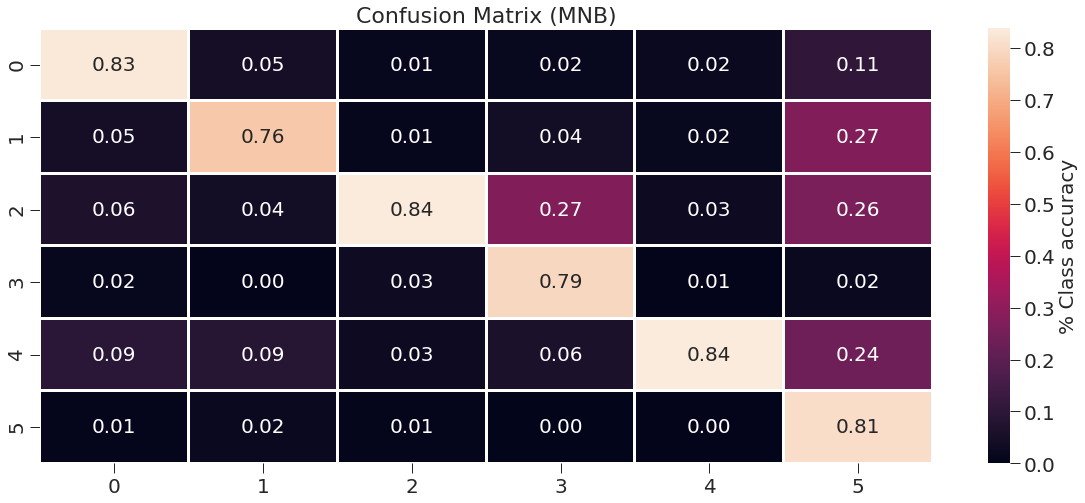

In [31]:
conf_mat=confusion_matrix(y_test,y_test_pred)
normalized_confusion_matrix(y_test,conf_mat,"MNB")

In [32]:
print(mnb.predict(vectorizer.transform(["I am afraid of loosing you."])))

['fear']


In [34]:
print(mnb.classes_,"\n",mnb.predict_proba(vectorizer.transform(["I am afraid of loosing you."])))

['anger' 'fear' 'happy' 'love' 'sadness' 'surprise'] 
 [[0.05403707 0.74176506 0.0423533  0.05859553 0.08096227 0.02228677]]


For a statement: `I am afraid of loosing you.` 
Top 3 predicted emotions based on probability in decreasing orders are: `fear`,`sadness` and `love`.

# Conclusion

- `MultinomialNB` machine learning model was used and `0.77 +/- 0.05` average f1 score  after 5 fold cross validation was achieved. 